<a href="https://colab.research.google.com/github/abhilash1910/EuroPython-21-QuantumDeepLearning/blob/master/Quantum_Gradients_with_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Quantum Gradients 

In this case, we will be looking at how to apply classical autodifferentiation libraries like [Tensorflow](https://www.tensorflow.org/) on quantum circuits for gradient convergence. To optimize your hybrid classical-quantum model using the TensorFlow eager interface, we have to  make use of the TensorFlow optimizers provided in the ```tf.train``` module, or your own custom TensorFlow optimizer.
Here we will be having 2 wires and associated angles (phi and theta). We will be applying the RX ,RY gates followed by a [CNOT](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.CNOT.html) and a [PauliZ](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.PauliZ.html) gate.
The cost function will try to match the qubit’s state — the direction it points on the Bloch sphere — to a target value, initially at the south pole. Using PennyLane’s automatic differentiation features and the built-in Tensorflow optimizers, we can adjust the circuit’s parameters until the qubit matches the target.

The ```cost_function``` in this case is created by subtracting the predicted values of the angles with the initial qubits state. Here we are using ```tf.GradientTape()``` ti view the gradients in eager execution mode. After ``n `` epochs we can visualize the final angles (gradients) of phi and theta. Pennylane's simulators are based on different autograd libraries which are mentioned in this diagram:

<img src="https://miro.medium.com/max/875/0*WGjgY1qwUYaVvafu">


In [ ]:
!pip install pennylane

In [ ]:
!pip install qiskit

### Methods for creating the Circuit and Optimizer

We are using a dual wired circuit with RX,RY,CNOT and PauliZ gates with the inference device as ```tf```. The ```cost_function``` contains the delta/errors at each step of the predicted angles and with the proposed angles (target values).This can be modified to have any loss equation as such.The ```initialize_tensor``` is used to create Tensorflow tensors from the input data.
The ```optimize_circuit``` method performs the gradient computation using ```tf.GradientTape()``` and ```keras.optimizers.SGD``` (Stochastic Gradient Descent). We compute the gradient at each step and apply those gradients at each step. Though this is computationally inefficient as getting each gradient values are computationally intensive. 

The final values are attained after creating the phi,theta initial angles and converting them to tf tensors and calling optimizer to converge the values. For the Torch counterpart of this segment, the [Xanadu blog](https://medium.com/xanaduai/training-quantum-neural-networks-with-pennylane-pytorch-and-tensorflow-c669108118cc) can be considered.

Gradients after 4 iterations:
Gradient 1:[-0.753474  0.      ] ,Gradient 2:[0. 0.] For the provided input tensor


Gradients after 9 iterations:
Gradient 1:[-2.554357  0.      ] ,Gradient 2:[-5.551115e-17  0.000000e+00] For the provided input tensor
Gradients after 14 iterations:
Gradient 1:[-1.1046525  0.       ] ,Gradient 2:[1.3877788e-17 0.0000000e+00] For the provided input tensor
Gradients after 19 iterations:
Gradient 1:[-0.415428  0.      ] ,Gradient 2:[-2.7755576e-17  0.0000000e+00] For the provided input tensor
Gradients after 24 iterations:
Gradient 1:[-0.22133559  0.        ] ,Gradient 2:[1.3877788e-17 0.0000000e+00] For the provided input tensor
Gradients after 29 iterations:
Gradient 1:[-0.14089514  0.        ] ,Gradient 2:[-6.938894e-18  0.000000e+00] For the provided input tensor
Gradients after 34 iterations:
Gradient 1:[-0.09926771  0.        ] ,Gradient 2:[0. 0.] For the provided input tensor
Gradients after 39 iterations:
Gradient 1:[-0.07462189  0.        ] ,Gradient 2:[6.938894e-18 0.000000e+00] For the provided input tensor
Gradients after 44 iterations:
Gradient 1:[-0.0586650

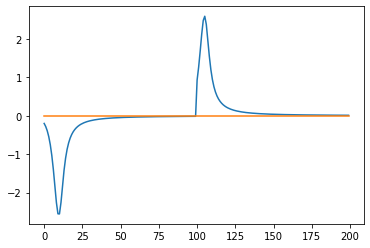

In [8]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

device=qml.device("default.qubit",wires=2)
@qml.qnode(device,interface='tf')
def create_circuit(inputs):
  qml.RX(inputs[0],wires=0)
  qml.RY(inputs[1],wires=1)
  qml.CNOT(wires=[0, 1])
  return qml.expval(qml.PauliZ(0))
  # return qml.expval(qml.PauliZ(0)@qml.PauliZ(1))
@tf.function
def cost_function(x,step):
  val=-(-1)**(step//100)
  #delta=tf.abs(tf.square(create_circuit(x)-val))
  delta= tf.reduce_mean(tf.square(create_circuit(x)-val))
  return delta

def initialize_tensor(angle_1,angle_2):
  tensors=[]
  phi=tf.Variable(angle_1)
  theta=tf.Variable(angle_2)
  tensors.append(phi)
  tensors.append(theta)
  return tensors

def optimize_circuit(tensors,steps):
  g0,g1,g2,g3=[],[],[],[]
  opt = tf.keras.optimizers.SGD(learning_rate=0.1)
  for i in range(steps):
    with tf.GradientTape() as tape:
      loss=cost_function(tensors,i)
    grads=tape.gradient(loss,tensors)
    opt.apply_gradients(zip(grads, tensors))
    
    g0.append(grads[0].numpy()[0])
    g1.append(grads[0].numpy()[1])
    g2.append(grads[1].numpy()[0])
    g3.append(grads[1].numpy()[1])
    if (i+1)%5==0:
      print(f"Gradients after {i} iterations:")
      print(f"Gradient 1:{grads[0]} ,Gradient 2:{grads[1]} For the provided input tensor")
  plt.plot(g0)
  #plt.plot(g1)
  plt.plot(g2)
  #plt.plot(g3)
  plt.show()
  return g0,g1,g2,g3    
    
phi=[0.05,0.87]
theta=[0.43,0.034]
tf_tensors=initialize_tensor(phi,theta)
conj_angles=[phi,theta]
#create_circuit(conj_angles)
steps=200
g0,g1,g2,g3=optimize_circuit(tf_tensors,steps)




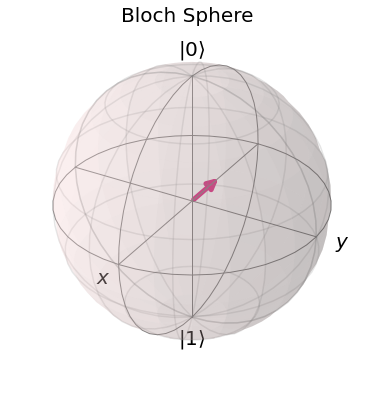

In [7]:
from qiskit.visualization import plot_bloch_vector
%matplotlib inline
final_anglex=g0[-1]
final_angley=g1[-1]
final_anglex1=g2[-1]
final_angley1=g3[-1]

rot_1=[final_anglex,final_angley,0]
rot_2=[final_anglex1,final_angley1,0]
plot_bloch_vector([rot_1], title="Bloch Sphere")
